# DATASET과 DATALOADER
##### 더 나은 가독성과 모듈성을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적이다.
##### PyTorch는 torch.utils.data.DataLoader와 torch.utils.data.Dataset의 두 가지 데이터 기본 요소를 제공하여 미리 준비해둔 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있게 한다.
##### Dataset은 샘플과 정답을 저장하고, DataLoader는 Dataset을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체로 감싼다.

## 데이터셋 불러오기
##### TorchVision에서 Fashion-MNIST 데이터셋을 불러오는 예제를 살펴보자
##### 흑백의 28X28 이미지와 10개 분류 중 하나인 정답으로 구성된다.
##### 매개변수 설명
##### root : 학습/테스트 데이터가 저장되는 경로
##### train : 학습용 또는 테스트용 데이터셋 여부를 지정
##### download=True : root에 데이터가 없는 경우 인터넷에서 다운로드
##### transform/target_transform : 특징과 정답 변형을 지정

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 17101872.13it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 305793.98it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5547289.59it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2659474.93it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## 데이터셋을 순회하고 시각화하기
##### Dataset에 리스트처럼 직접 접근할 수 있다.
##### training_data[index], matplotlib을 사용하여 확습 데이터의 일부를 시각화하자

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

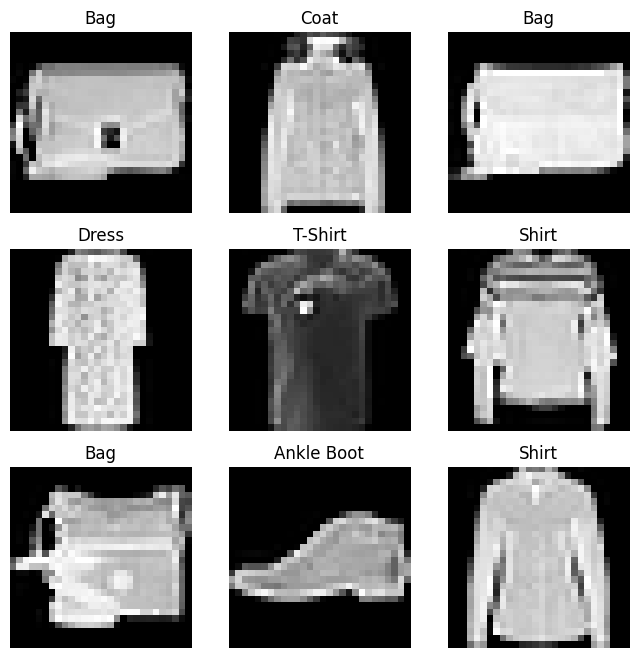

In [3]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 파일에서 사용자 정의 데이터셋 만들기
##### 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 한다. : _ _init_ _, _ _len_ _, _ _getitem_ _
##### 아래는 FashionMNIST 이미지들은 img_dir 디렉토리에 저장되고, 정답은 annotations_file csv파일에 별도로 저장된다.

In [4]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## _ _init_ _
##### init 함수는 Dataset 객체가 생성될 때 한 번만 실행된다.
##### 여기서는 이미지와 주석 파일이 포함된 디렉토리와 두 가지 변형을 초기화한다.

In [5]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
  self.img_labels = pd.read_csv(annotations_file)
  self.img_dir = img_dir
  self.transform = transform
  self.target_transform = target_transform

## _ _len_ _
##### len 함수는 데이터셋의 샘플 개수를 반환한다.

In [6]:
def __len__(self):
  return len(self.img_labels)

## _ _getitem_ _
##### getitem 함수는 주어진 인덱스(idx)에 해당하는 샘플을 데이터셋에서 불러오고 반환한다.
##### 인덱스를 기반으로 디스크에서 이미지의 위치를 식별하고, read_image를 사용하여 이미지를 텐서로 반환하고, self.img_labels의 csv 데이터로부터 해당하는 정답을 가져오고, 변형 함수들을 호출한 뒤, 텐서 이미지와 라벨을 python 사전형으로 반환한다.

In [7]:
def __getitem__(self, idx):
  img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
  image = read_image(img_path)
  label = self.img_labels.iloc[idx,1]
  if self.transform:
    image = self.transform(image)
  if self.target_transform:
    label = self.target_transform(label)
  sample = {"image":image, "label":label}
  return sample

## DataLoader로 학습용 데이터 준비하기
##### Dataset은 데이터셋의 특징을 가져오고 하나의 샘플에 정답을 지정하는 일을 한 번에 한다.
##### 모델을 학습할 때, 일반적으로 샘플들을 미니배치로 전달하고, 매 에폭마다 데이터를 다시 섞어서 과적합을 막고 python은 multiprocessing을 사용하여 검색 속도를 높인다.
##### DataLoader는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체이다.

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## DataLoader를 통해 순회하기(iterate)
##### DataLoader에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회할 수 있다.
##### 아래의 각 순회에는 train_features와 train_labels의 묶음을 반환한다.
##### shuffle=True 이므로, 모든 배치를 순회한 뒤 데이터가 섞인다.

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


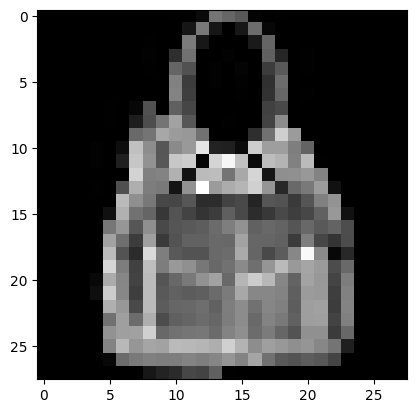

Label: 8


In [9]:
# 이미지와 정답을 표시한다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label: {label}")